<div style="text-align: center; margin: 50px">

<h1 style="color: white; background-color: grey; text-align: center;">Amplitude Estimation using Rabi Experiment with Estimated Frequency of Qubit</h1>

</div>

### Overview:
1. [Importing Necessary Libraries and Provider](#part1)<br><br>
2. [Frequency Estimation](#part2)<br><br>
3. [Rabi Experiment Set-up](#part3)<br><br>
4. [Getting Amplitude value for 90 degree X-rotation gate](#part4)<br><br>

<a id = 'part1'></a>
## Importing Necessary Libraries And Provider:

In [1]:
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit import assemble, pulse, QuantumCircuit,\
 schedule, transpile
from qiskit.circuit import Gate
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.pulse.library import Gaussian
from qiskit.test import mock
from qiskit.visualization import plot_histogram
from qiskit.visualization.pulse_v2 import draw
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


In [3]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
backend_defaults = backend.defaults()

<a id = 'part2'></a>
## Frequency Estimation:

In [4]:
qubit_freq= backend_defaults.qubit_freq_est[0]
print(f"Estimated freq for our qubit:  "
      f"{round(qubit_freq / 1.0e9, 5)} GHz")
print(qubit_freq)

Estimated freq for our qubit:  4.97166 GHz
4971662785.80752


<a id = 'part3'></a>
## Rabi Experiment Set-up:

In [5]:
drive_amps = np.linspace(0, 0.75, 50)
drive_amp = 0.05
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)
qubit = 0
mem_slot = 0
drive_sigma_sec = 0.075 * 1.0e-6                         
drive_duration_sec = drive_sigma_sec * 8   

In [6]:
from qiskit import pulse
from qiskit.circuit import Parameter      


drive_amp = Parameter("drive_amp")
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = 2704
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

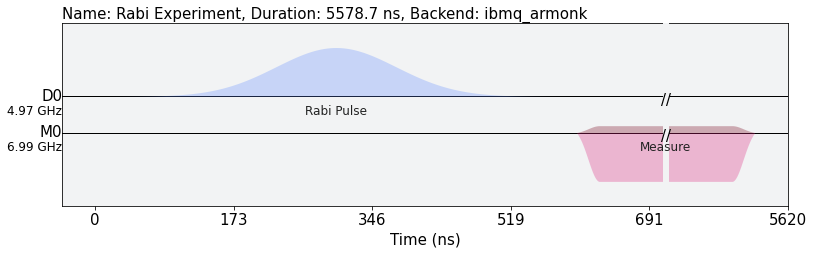

In [7]:
rabi_schedules[-1].draw(backend=backend)

Job Status: job has successfully run


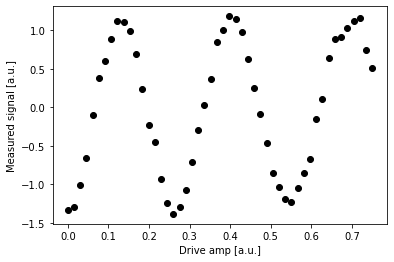

In [8]:
num_shots_per_point = 1024

job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)
rabi_results = job.result(timeout=120)
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []
for i in range(50):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * 1e-14)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

<a id = 'part4'></a>
## Getting Amplitude value for 90 degree X-rotation gate:

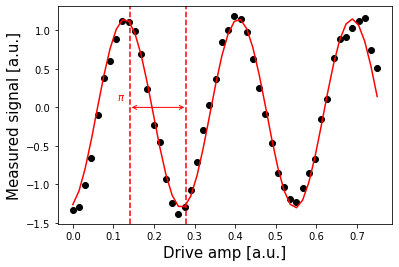

In [9]:
from scipy.optimize import curve_fit

## fitting curve to fetch value

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [10]:
half_pi_amp = abs(drive_period / 4)
print(f"Half Pi Amplitude = {half_pi_amp}")

Half Pi Amplitude = 0.06998252668221455
